In [435]:
!pip install jovian --upgrade --quiet

In [436]:
import torch 
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


In [437]:
dataset = MNIST(root = 'data/', download=True, transform = ToTensor())

torch.Size([1, 28, 28])
Label : 5


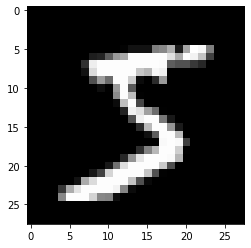

In [438]:
image, label = dataset[0]
print(image.shape)
plt.imshow(image[0],cmap='gray')
print('Label :',label)

In [439]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds),len(val_ds)

(50000, 10000)

In [440]:
batch_size = 64

In [441]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True )

image.shape: torch.Size([1, 28, 28])


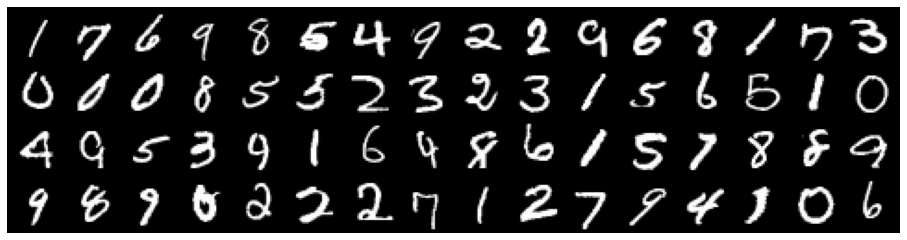

In [442]:
for images,_ in train_loader:
  print('image.shape:',image.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
  break

In [443]:
for images, labels in train_loader:
  print('image.shape', image.shape)
  inputs = images.reshape(-1, 784)
  print('inputs.shape',inputs.shape)
  break

image.shape torch.Size([1, 28, 28])
inputs.shape torch.Size([64, 784])


In [444]:
input_size = inputs.shape[-1]
hidden_size = 64

In [445]:
layer1 = nn.Linear(input_size, hidden_size)

In [446]:
inputs.shape

torch.Size([64, 784])

In [447]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape', layer1_outputs.shape)

layer1_outputs.shape torch.Size([64, 64])


In [448]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([64, 64])

In [449]:
torch.allclose(layer1_outputs_direct, layer1_outputs, 1e-3)

True

In [450]:
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))


tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [451]:
layer1_outputs.shape

torch.Size([64, 64])

In [452]:
relu_outputs = F.relu(layer1_outputs)
print('relu_outputs.shape:', relu_outputs.shape)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

relu_outputs.shape: torch.Size([64, 64])
min(layer1_outputs): -0.8360680341720581
min(relu_outputs): 0.0


In [453]:
outputs_size = 10
layer2 = nn.Linear(hidden_size, outputs_size)

In [454]:
layer2_outputs  = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([64, 10])


In [455]:
inputs.shape

torch.Size([64, 784])

In [456]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3223, grad_fn=<NllLossBackward>)

In [457]:
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [458]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [459]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [460]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, outputs_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [461]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [462]:
torch.allclose(outputs2, outputs3, 1e-3)

False

In [463]:
# Install the library
!pip install jovian --upgrade --quiet

In [464]:
import jovian

In [465]:
jovian.commit(project='practice-feed-neural-network')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/raghavsodhi02/practice-feed-neural-network


'https://jovian.ai/raghavsodhi02/practice-feed-neural-network'

In [466]:
class MnistModel(nn.Module):
  def __init__(self, in_size, hidden_size, interout1_size, interout, out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, interout1_size)
    self.linear3 = nn.Linear(interout1_size, interout)
    self.linear4 = nn.Linear(interout,out_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images) 
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]      
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc']for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [467]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [468]:
input_size = 784
hidden_size = 128 # you can change this
num_classes = 10
interout1_size = 64
interout =32

In [469]:
model = MnistModel(input_size, hidden_size, interout1_size, interout, out_size=num_classes)

In [470]:
for t in model.parameters():
    print(t.shape)

torch.Size([128, 784])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [471]:
for images, labels in train_loader:
  outputs = model(images)
  break

loss = F.cross_entropy(outputs, labels)
print('loss:', loss.item())
print('outputs.shape : ', outputs.shape)
print('Sample outputs : \n', outputs[:2].data)  

loss: 2.3311455249786377
outputs.shape :  torch.Size([64, 10])
Sample outputs : 
 tensor([[ 0.2300, -0.0707, -0.1209, -0.1235, -0.0837, -0.1318, -0.2452,  0.0501,
          0.0331, -0.0335],
        [ 0.2178, -0.0770, -0.1401, -0.1233, -0.0879, -0.1019, -0.2533,  0.0525,
          0.0227, -0.0171]])


In [472]:
torch.cuda.is_available()

True

In [473]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')  

In [474]:
device = get_default_device()
device

device(type='cuda')

In [475]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)  

In [476]:
for images, labels in train_loader:
    print(images.shape)
    print(image.device)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([64, 1, 28, 28])
cpu
cuda:0


In [477]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)      
    

In [478]:
def some_numbers():
  yield 10
  yield 20
  yield 30

for value in some_numbers():
  print(value)  

10
20
30


In [479]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [480]:
for xb, yb in val_loader:
  print('xb.device:', xb.device)
  print('yb:',yb)
  break

xb.device: cuda:0
yb: tensor([3, 9, 0, 2, 5, 8, 1, 7, 0, 7, 5, 4, 4, 3, 0, 7, 2, 8, 2, 0, 4, 9, 4, 6,
        1, 4, 2, 5, 0, 1, 6, 5, 5, 0, 9, 5, 9, 7, 0, 4, 4, 1, 5, 3, 7, 6, 1, 7,
        1, 9, 8, 4, 2, 0, 0, 4, 8, 2, 4, 6, 7, 4, 8, 9, 8, 2, 7, 8, 2, 9, 1, 4,
        4, 6, 1, 7, 1, 7, 3, 8, 6, 5, 9, 4, 4, 1, 6, 6, 3, 0, 8, 2, 8, 0, 0, 8,
        7, 9, 0, 1, 2, 0, 1, 6, 8, 4, 8, 9, 5, 0, 4, 8, 8, 4, 5, 8, 7, 1, 9, 0,
        7, 0, 9, 8, 4, 0, 6, 6], device='cuda:0')


In [481]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [482]:
# Model (on GPU)
model = MnistModel(input_size,hidden_size, interout1_size, interout, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=10, bias=True)
)

In [483]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.09355221688747406, 'val_loss': 2.3092262744903564}]

In [484]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3733, val_acc: 0.9158
Epoch [1], val_loss: 0.1266, val_acc: 0.9618
Epoch [2], val_loss: 0.1144, val_acc: 0.9686
Epoch [3], val_loss: 0.1114, val_acc: 0.9683
Epoch [4], val_loss: 0.1981, val_acc: 0.9527


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
!pip install jovian --upgrade -q

In [ ]:
import jovian

In [ ]:
jovian.commit(project='practice-feed-neural-network', environment=None)

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[139]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[1093]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

In [ ]:

torch.save(model.state_dict(), 'practice-mnist-feedforward.pth')

In [ ]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_loss'])

In [ ]:
jovian.commit(project='practice-feed-neural-network', 
              environment=None, 
              outputs=['practice-mnist-feedforward.pth'])